In [242]:
from __future__  import print_function, division

In [316]:
import os
import pandas as pd
import matplotlib.pylab as plt
import scipy.stats as st
%matplotlib inline

In [244]:
os.getenv('PUIDATA')

'/home/cusp/sgo230/PUIdata'

In [245]:
# Federica's function, fixed bug with file type

def getCitiBikeCSV(datestring):
    print ("Downloading", datestring)
    ### First I will heck that it is not already there
    if not os.path.isfile(os.getenv("PUIDATA") + "/" + datestring + "-citibike-tripdata.csv"):
        if os.path.isfile(datestring + "-citibike-tripdata.csv"):
            # if in the current dir just move it
            if os.system("mv " + datestring + "-citibike-tripdata.csv " + os.getenv("PUIDATA")):
                print ("Error moving file!, Please check!")
        #otherwise start looking for the zip file
        else:
            if not os.path.isfile(os.getenv("PUIDATA") + "/" + datestring + "-citibike-tripdata.zip"):
                if not os.path.isfile(datestring + "-citibike-tripdata.zip"):
                    os.system("curl -O https://s3.amazonaws.com/tripdata/" + datestring + "-citibike-tripdata.zip")
                ###  To move it I use the os.system() functions to run bash commands with arguments
                os.system("mv " + datestring + "-citibike-tripdata.zip " + os.getenv("PUIDATA"))
            ### unzip the csv 
            os.system("unzip " + os.getenv("PUIDATA") + "/" + datestring + "-citibike-tripdata.csv")
            ## NOTE: old csv citibike data had a different name structure. 
            if '2014' in datestring:
                os.system("mv " + datestring[:4] + '-' +  datestring[4:] + 
                          "\ -\ Citi\ Bike\ trip\ data.csv " + datestring + "-citibike-tripdata.csv")
            os.system("mv " + datestring + "-citibike-tripdata.csv " + os.getenv("PUIDATA"))
    ### One final check:
    if not os.path.isfile(os.getenv("PUIDATA") + "/" + datestring + "-citibike-tripdata.csv"):
        print ("WARNING!!! something is wrong: the file is not there!")

    else:
        print ("file in place, you can continue")

In [246]:
datestring = '201707'
getCitiBikeCSV(datestring)

file in place, you can continue


In [247]:
df = pd.read_csv(os.getenv("PUIDATA") + '/201707-citibike-tripdata.csv')

In [44]:
# Idea: Younger people are more likely to ride Citi Bikes late at night

In [45]:
#Null hypothesis:
#The proportion of riders 35+ to total riders for trips starting at midnight-5 am is higher or equal
#to the proportion of riders 35+ to total riders for trips starting at 5 am - midnight

#H0:
#$\frac{old_riders{\mathrm{night}}}{all_riders{\mathrm{night}}} >= frac{old_riders{\mathrm{day}}}{old_riders{\mathrm{day}}}$

#Ha:
#$\frac{old_riders{\mathrm{night}}}{all_riders{\mathrm{night}}} < frac{old_riders{\mathrm{day}}}{old_riders{\mathrm{day}}}$

# Testing this hypothesis at the 95% confidence level (alpha of 5%)

In [248]:
# Clean and add fields to dataframe
df['date'] = pd.to_datetime(df['starttime'])
df['age'] = 2017 - df['birth year']
df['hour'] = df['date'].dt.hour

In [249]:
# Present sample of data frame
df.head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender,date,age,hour
0,364,2017-07-01 00:00:00,2017-07-01 00:06:05,539,Metropolitan Ave & Bedford Ave,40.715348,-73.960241,3107,Bedford Ave & Nassau Ave,40.723117,-73.952123,14744,Subscriber,1986.0,1,2017-07-01 00:00:00,31.0,0
1,2142,2017-07-01 00:00:03,2017-07-01 00:35:46,293,Lafayette St & E 8 St,40.730207,-73.991026,3425,2 Ave & E 104 St,40.789210,-73.943708,19587,Subscriber,1981.0,1,2017-07-01 00:00:03,36.0,0
2,328,2017-07-01 00:00:08,2017-07-01 00:05:37,3242,Schermerhorn St & Court St,40.691029,-73.991834,3397,Court St & Nelson St,40.676395,-73.998699,27937,Subscriber,1984.0,2,2017-07-01 00:00:08,33.0,0
3,2530,2017-07-01 00:00:11,2017-07-01 00:42:22,2002,Wythe Ave & Metropolitan Ave,40.716887,-73.963198,398,Atlantic Ave & Furman St,40.691652,-73.999979,26066,Subscriber,1985.0,1,2017-07-01 00:00:11,32.0,0
4,2534,2017-07-01 00:00:15,2017-07-01 00:42:29,2002,Wythe Ave & Metropolitan Ave,40.716887,-73.963198,398,Atlantic Ave & Furman St,40.691652,-73.999979,29408,Subscriber,1982.0,2,2017-07-01 00:00:15,35.0,0


In [250]:
# Reduce df (simpler method than dropping long list of columns)
df = df[['hour', 'age']]

In [251]:
# Clean up and create flag/dummy fields for binary data
df['age_group'] = df['age'] >= 35
age_dict = {True: '35+', False: '<35'}
df['age_group'] = df['age_group'].map(age_dict)

df['time'] = df['hour'] < 5
time_dict = {True: 'Late Night', False: 'Daytime'}
df['time'] = df['time'].map(time_dict)

In [252]:
# Present sample of redacted dataframe
df.head()

,hour,age,age_group,time
0,0,31.0,<35,Late Night
1,0,36.0,35+,Late Night
2,0,33.0,<35,Late Night
3,0,32.0,<35,Late Night
4,0,35.0,35+,Late Night


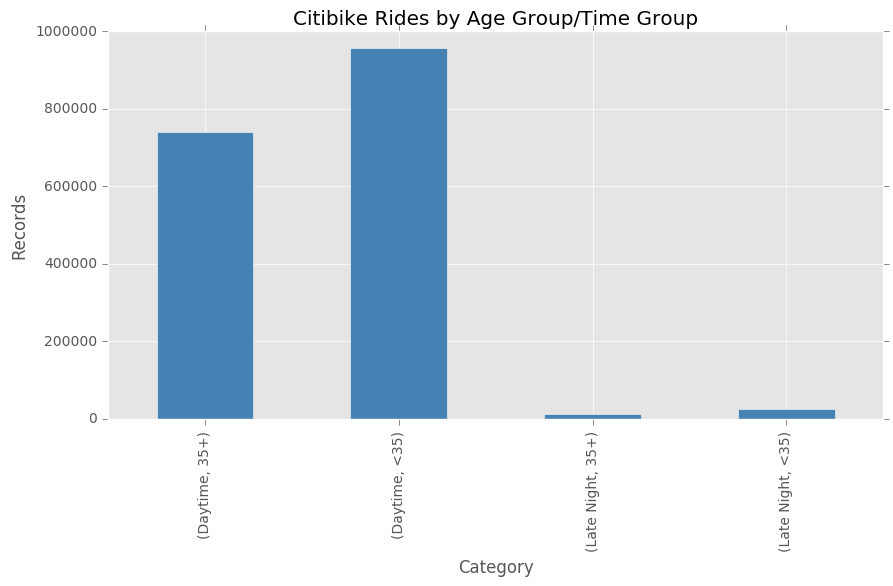

In [253]:
fig = plt.figure(figsize(10,5))
plt.style.use('ggplot')
df.groupby(['time', 'age_group']).size().plot(kind='bar', color = 'Steelblue')
plt.xlabel('Category')
plt.ylabel('Records')
plt.title('Citibike Rides by Age Group/Time Group')

In [273]:
print(df.groupby(['time']).size())

time
Daytime       1696632
Late Night      38967
dtype: int64


In [274]:
daytime = df.groupby(['time']).size()[0]
nighttime = df.groupby(['time']).size()[1]

print("Number of total daytime riders: {:,}"\
      .format(daytime, grouping=True))
print("Number of total nighttime riders: {:,}"\
      .format(nighttime, grouping=True))

Number of total daytime riders: 1,696,632
Number of total nighttime riders: 38,967


In [275]:
print(df[df['time']=='Daytime'].groupby(['time', 'age_group']).size(),'\n')
print(df[df['time']=='Late Night'].groupby(['time', 'age_group']).size())

time     age_group
Daytime  35+          739363
         <35          957269
dtype: int64 

time        age_group
Late Night  35+          13184
            <35          25783
dtype: int64


In [289]:
day_prop = (df[df['time']=='Daytime'].groupby(['time', 'age_group']).size() / daytime)[0]
night_prop = (df[df['time']=='Late Night'].groupby(['time', 'age_group']).size() / nighttime)[0]

print("Proportion of 35+ riders during the day: {:.4f}"\
     .format(day_prop))
print("Proportion of 35+ riders during the day: {:.4f}"\
     .format(night_prop))

Proportion of 35+ riders during the day: 0.4358
Proportion of 35+ riders during the day: 0.3383


In [322]:
P0mP1 = day_prop - night_prop
print ("Difference between share of 35+ during day vs. late night: {:.4}"\
       .format(P0mP1))
if P0mP1 <= 0:
    # we are done...
    print("In accordance with Null Hypothesis")
else:
    # morework to do
    print ("We must check the significance before we reject the Null Hypothesis")

Difference between share of 35+ during day vs. late night: 0.09745
We must check the significance before we reject the Null Hypothesis


In [311]:
# Generate functions for testing
def proportion(p0,p1,n0,n1):
    '''Get value of P
    p0 = Control value (dayttime proportion)
    p1 = Experimental value (nighttime proportion)
    n0 = Control samples (daytime rides)
    n1 = Experimental samples (nighttime rides)
    '''
    return (p0 * n0 + p1 * n1) / (n0 + n1)

def standard_error(p, n0, n1):
    '''Get standard error/standard deviation
    p = Value generated from proportion formula
    n0 = Control samples
    n1 = Experimental samples
    '''
    return (p * (1 - p) * (1 / n0 + 1 / n1)) ** 0.5

def z_score(p0, p1, se):
    '''Get z-score for experiment
    p0 = Control value
    p1 = Experimental Value
    se = Standard error generated from proportion formula
    '''
    return (p0 - p1) / se

In [320]:
# Get results
p0 = day_prop
p1 = night_prop
n0 = daytime
n1 = nighttime

p = proportion(p0, p1, n0, n1)
print("p: {:.6f}"\
      .format(p))

se = standard_error(p, n0, n1)
print("se: {:.6f}"\
     .format(se))

z = z_score(p0, p1, se)
print("z-score: {:.6f}"\
     .format(z))

p: 0.433595
se: 0.002539
z-score: 38.377124


In [324]:
# Based on z-score of 38+ (well below p = 0.05 - basically 0, in fact), we reject the null hypothesis